In [46]:
#michael cho cs final capstone project
import pandas as pd
import numpy as np
import os
import unicodedata
import re
import shutil
import splitfolders
from os import listdir
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
from tensorflow.keras.optimizers import Adam
from keras.metrics import Recall, Precision
import openpyxl
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
                            classification_report
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import warnings
warnings.simplefilter(action='ignore')

In [47]:
# part 1
train_images_path = 'C:/Users/micha/dataset_hist_structures 2/dataset_hist_structures 2/dataset_hist_structures/Dataset_test/Dataset_test_original_1478'
test_images_path = 'C:/Users/micha/dataset_hist_structures 2/dataset_hist_structures 2/dataset_hist_structures/Dataset_test/Dataset_test_original_1478'
output_images_path = 'C:/Users/micha/output'
output_train_images_path = 'C:/Users/micha/output/train'
output_val_images_path = 'C:/Users/micha/output/val'


In [48]:
def get_file_ext(file_name):
    split_tup = os.path.splitext(file_name)
    return split_tup[1]
def is_image_file(file_ext):
    if file_ext.lower() == '.jpeg' or file_ext.lower() == '.jpg' or \
        file_ext.lower() == '.gif' or file_ext.lower() == '.png':
        return True
    else:
        return False
def list_image_files(rootdir):
    images_dirs = listdir(path=rootdir)
    image_dir_dict = {}
    i = 1
    print('-------------------------------------------------------------')
    print(f'Following sub-directories found in "{rootdir}" directory')
    for dirs in images_dirs:
        print(f'{i}: {dirs}')
        i = i+1
    print('-------------------------------------------------------------')
    total_image_count = 0
    image_file_list = []
    for dirs in images_dirs:
        file_list = listdir(path=rootdir + '/' + dirs)
        image_files = [ file_name for file_name in file_list \
                       if is_image_file(get_file_ext(file_name)) ]
        image_count = len(image_files)
        total_image_count = total_image_count + image_count
        image_dir_dict[dirs] = image_count
        image_file_list = image_file_list + \
                            [ rootdir + '/' + dirs + '/' + \
                             image_name for image_name in image_files]
    print(f'Total images found = {total_image_count}')
    for key in image_dir_dict.keys():
        dir_image_count = image_dir_dict[key]
        print(f'Directory "{key}" contains {dir_image_count} image files' + \
              f' = {round(dir_image_count/total_image_count,3):.3%}')
    return image_file_list
def get_random_image_files(rootdir, random_count):
    image_file_list = []
    images_dirs = listdir(path=rootdir)
    for dirs in images_dirs:
        file_list = listdir(path=rootdir + '/' + dirs)
        image_files = [ file_name for file_name in file_list \
                       if is_image_file(get_file_ext(file_name)) ]
        image_file_list = image_file_list + \
            random.choices([ rootdir + '/' + dirs + '/' + \
                            image_name for image_name in image_files],\
                           k=random_count)
    return image_file_list

-------------------------------------------------------------
Following sub-directories found in "C:/Users/micha/dataset_hist_structures 2/dataset_hist_structures 2/dataset_hist_structures/Dataset_test/Dataset_test_original_1478" directory
1: altar
2: apse
3: bell_tower
-------------------------------------------------------------
Total images found = 290
Directory "altar" contains 140 image files = 48.300%
Directory "apse" contains 57 image files = 19.700%
Directory "bell_tower" contains 93 image files = 32.100%
-------------------------------------------------------------
Following sub-directories found in "C:/Users/micha/dataset_hist_structures 2/dataset_hist_structures 2/dataset_hist_structures/Dataset_test/Dataset_test_original_1478" directory
1: altar
2: apse
3: bell_tower
-------------------------------------------------------------
Total images found = 290
Directory "altar" contains 140 image files = 48.300%
Directory "apse" contains 57 image files = 19.700%
Directory "bell_tow

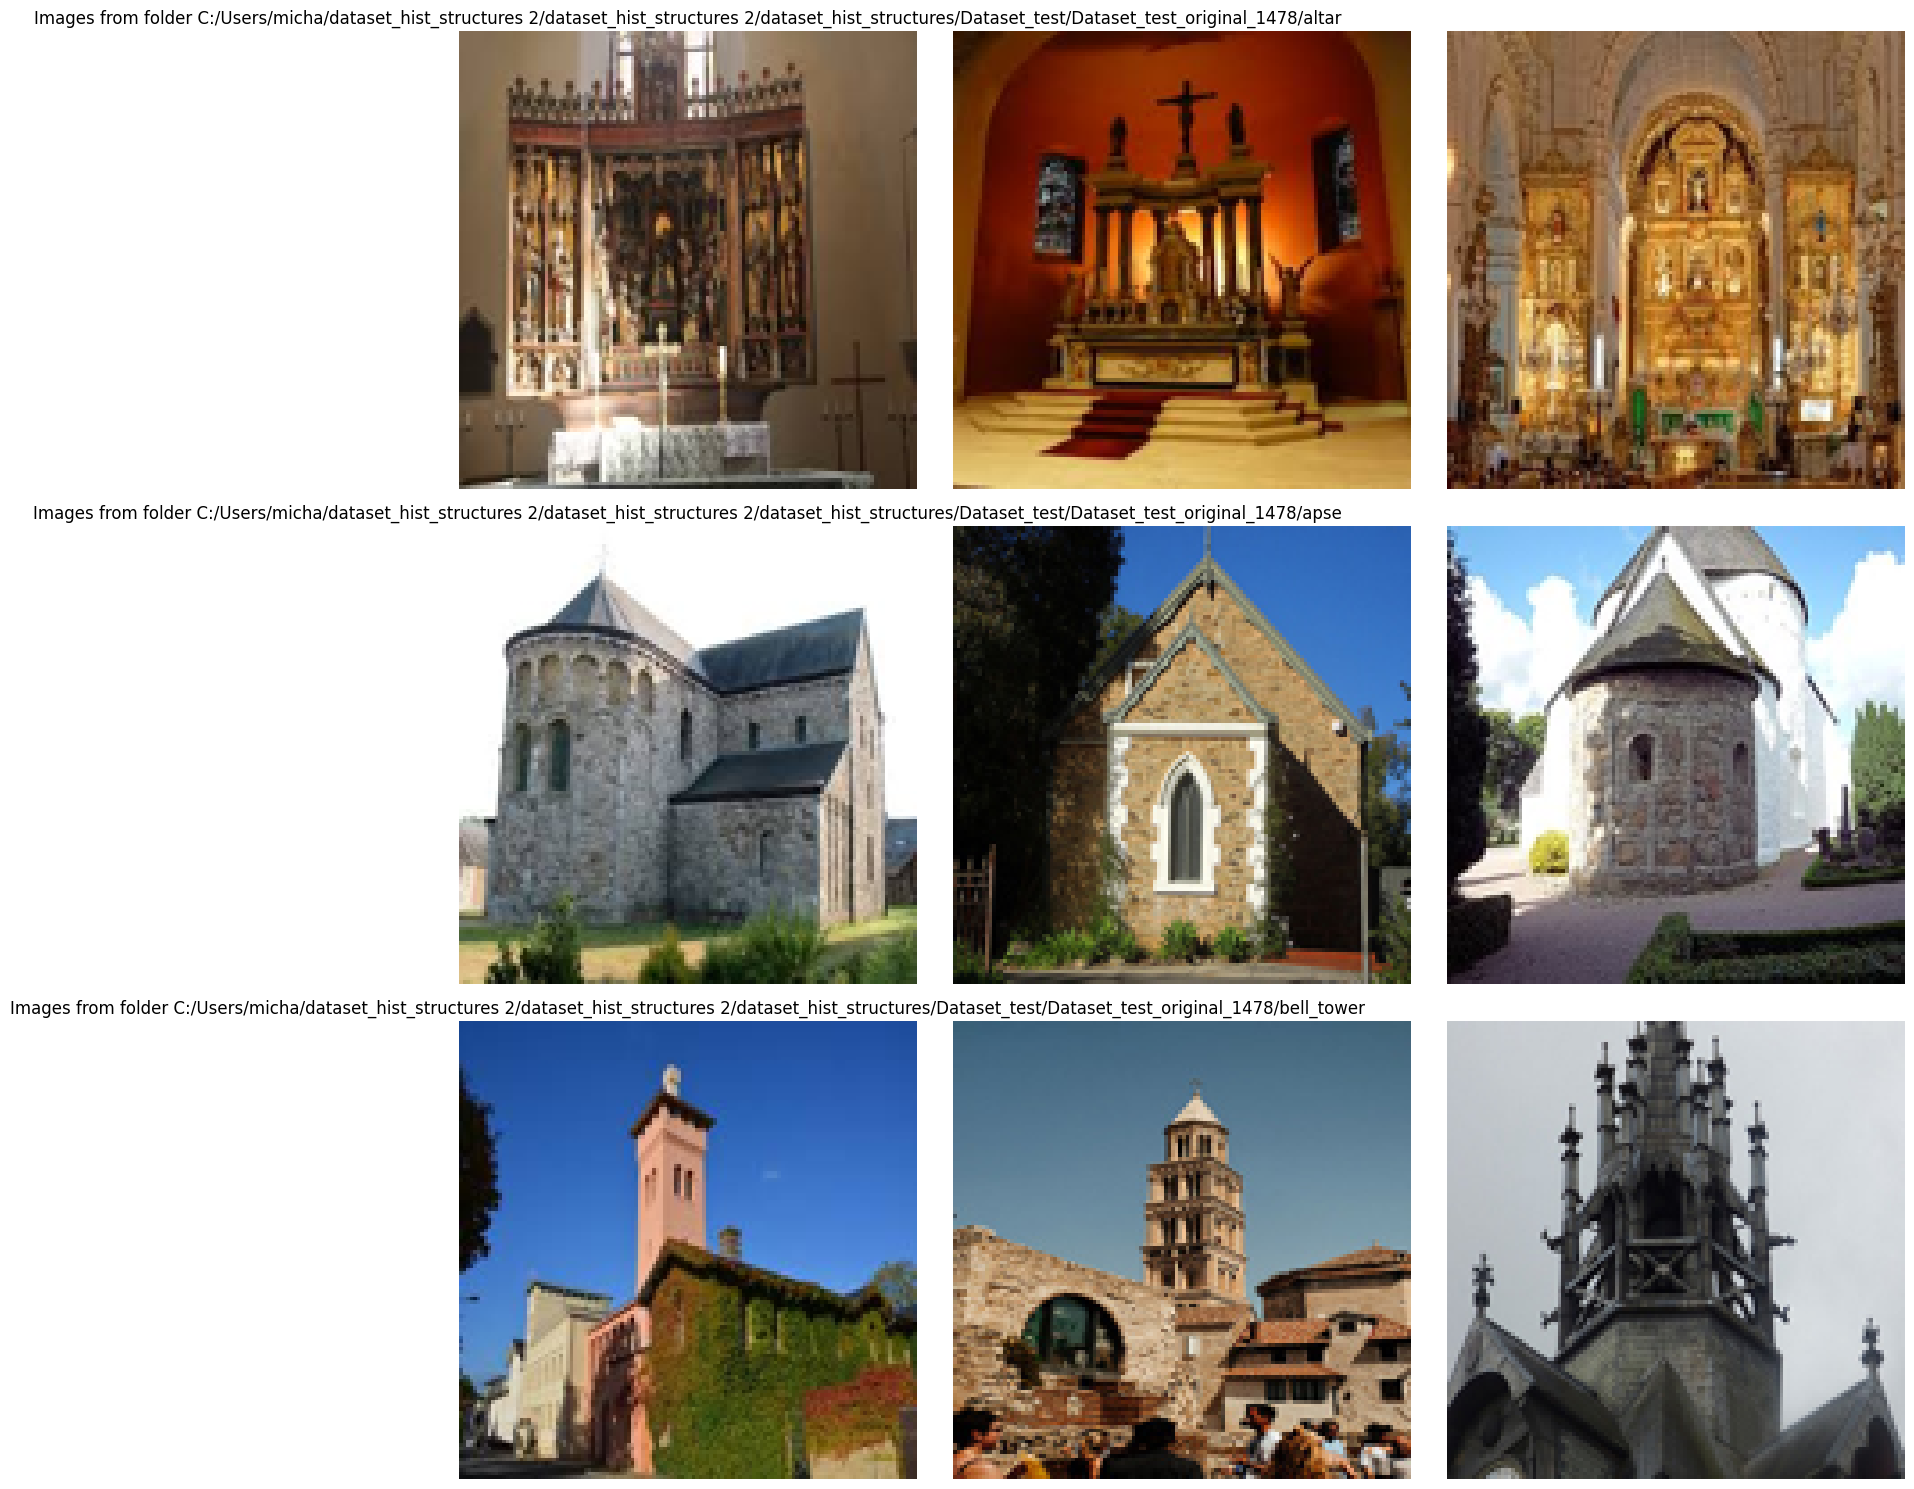

Directory ./C:/Users/micha/output does not exist
-------------------------------------------------------------
Following sub-directories found in "C:/Users/micha/output/train" directory
1: altar
2: apse
3: bell_tower
-------------------------------------------------------------
Total images found = 231
Directory "altar" contains 112 image files = 48.500%
Directory "apse" contains 45 image files = 19.500%
Directory "bell_tower" contains 74 image files = 32.000%
-------------------------------------------------------------
Following sub-directories found in "C:/Users/micha/output/val" directory
1: altar
2: apse
3: bell_tower
-------------------------------------------------------------
Total images found = 59
Directory "altar" contains 28 image files = 47.500%
Directory "apse" contains 12 image files = 20.300%
Directory "bell_tower" contains 19 image files = 32.200%


In [49]:
train_images_file_list = list_image_files(train_images_path)
test_images_file_list = list_image_files(test_images_path)
images_per_folder = 3
images_resized = []
image_dim = set()
images_file_list = get_random_image_files(train_images_path, images_per_folder)
for path in images_file_list:
    img = Image.open(path)
    if img is not None:
        width, height = img.size
        depth = len(img.getbands())
        image_dim.add((width,height,depth))
    else:
        print(f'Image {path} could not be loaded.')
    images_resized.append(img.resize((128, 128)) )
n_rows = len(images_resized)//images_per_folder
n_rows = len(images_resized)//images_per_folder
n_cols = images_per_folder
fig, axs = plt.subplots(n_rows, n_cols,figsize = (15, 5*n_rows))
for rows in range(n_rows):
    folder_name = images_file_list[rows*n_cols].rsplit('/',1)[0]
    axs[rows, 0].set_title(f'Images from folder {folder_name}')
    for cols in range(n_cols):
        axs[rows][cols].imshow(images_resized[rows*n_cols+cols])
        axs[rows][cols].axis('off')
plt.tight_layout()
plt.show()
image_dim
def create_output_dir(output_folder_name):
    output_folder = './' + output_folder_name
    # Check if the directory exists
    if os.path.exists(output_folder):
        # If it exists, remove it (and all its contents)
        shutil.rmtree(output_folder)
        print(f"Directory {output_folder} has been removed")
    else:
        # If the directory does not exist, do nothing
        print(f"Directory {output_folder} does not exist")
create_output_dir(output_images_path)
splitfolders.ratio(train_images_path, output=output_images_path, seed=1, \
                   ratio=(0.8, 0.2), group_prefix=None)
train_list = list_image_files(output_train_images_path)
val_list = list_image_files(output_val_images_path)

In [50]:
#random seed
tf.random.set_seed(1)

train_datagen = \
    ImageDataGenerator(preprocessing_function = \
                       tf.keras.applications.vgg16.preprocess_input, \
                       rescale=1./255, \
                       rotation_range=20, \
                       width_shift_range=0.2, \
                       height_shift_range=0.2, \
                       shear_range=0.2, \
                       zoom_range=0.2, \
                       horizontal_flip=True, \
                       fill_mode='nearest')
train_generator = \
    train_datagen.flow_from_directory(\
        output_train_images_path,\
        target_size=(224, 224),\
        batch_size=32,\
        classes=[ "altar", "apse", "bell_tower"  ], \
        class_mode='categorical',\
        shuffle=True)

val_datagen = \
    ImageDataGenerator(preprocessing_function = \
                       tf.keras.applications.vgg16.preprocess_input, \
                       rescale=1./255)
validation_generator = \
    val_datagen.flow_from_directory(\
        output_val_images_path,\
        target_size=(224, 224),\
        batch_size=32,\
        classes=[ "altar", "apse", "bell_tower" ], \
        class_mode='categorical',\
        shuffle=True)

test_datagen = \
    ImageDataGenerator(preprocessing_function = \
                       tf.keras.applications.vgg16.preprocess_input, \
                       rescale=1./255)
test_generator = \
    test_datagen.flow_from_directory(\
        test_images_path,\
        target_size=(224, 224),\
        batch_size=32,\
        classes=[ "altar", "apse", "bell_tower" ], \
        class_mode='categorical', \
        shuffle=True)


Found 231 images belonging to 3 classes.
Found 59 images belonging to 3 classes.
Found 290 images belonging to 3 classes.


In [51]:
#model running
base_model = VGG16(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)  # Final classification layer

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 15,243,075 (58.15 MB)

 Trainable params: 15,243,075 (58.15 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer=Adam(learning_rate=0.01), \
              loss='categorical_crossentropy', \
              metrics=['accuracy',Precision(),Recall()])
weights = \
    class_weight.compute_class_weight(\
        'balanced', \
        classes=np.unique(train_generator.classes),
        y=train_generator.classes)
class_weights = dict(enumerate(weights))
history = model.fit(train_generator, \
                    steps_per_epoch = train_generator.samples // 256, \
                    validation_data = validation_generator, \
                    validation_steps = validation_generator.samples // 256,\
                    class_weight=class_weights,\
                    epochs = 5)

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.4115 - loss: 4.5676 - precision_10: 0.3895 - recall_10: 0.3618 - val_accuracy: 0.4746 - val_loss: 1.1612 - val_precision_10: 0.5091 - val_recall_10: 0.4746
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.5008 - loss: 1.2353 - precision_10: 0.5429 - recall_10: 0.3864 - val_accuracy: 0.5593 - val_loss: 0.8289 - val_precision_10: 0.8065 - val_recall_10: 0.4237
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - accuracy: 0.7028 - loss: 0.7203 - precision_10: 0.8097 - recall_10: 0.5271 - val_accuracy: 0.9322 - val_loss: 0.4587 - val_precision_10: 0.9630 - val_recall_10: 0.8814
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.7777 - loss: 0.6137 - precision_10: 0.8740 - recall_10: 0.7234 - val_accuracy: 0.9322 - val_loss: 0.3126 - val_precision_10: 0.9474 - val_recall_10: 0.9153
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.8041 - loss: 0.4662 - precision_10: 0.8179 - recall_10: 0.7970 - val_ac

In [53]:
#callback
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=7, \
                                  restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, \
                              patience=3, min_lr=0.00001)
model.compile(optimizer=Adam(learning_rate=0.001), \
              loss='categorical_crossentropy', \
              metrics=['accuracy',Precision(),Recall()])
history = model.fit(train_generator, \
                    steps_per_epoch = train_generator.samples // 256, \
                    validation_data = validation_generator, \
                    validation_steps = validation_generator.samples // 256,\
                    callbacks=[early_stopping_cb, reduce_lr],\
                    class_weight=class_weights,\
                    epochs = 15)
history_df = pd.DataFrame(history.history)
if early_stopping_cb.stopped_epoch == 0:
  stopped_epoch = 10
else:
  stopped_epoch = early_stopping_cb.stopped_epoch

test_loss, test_acc, test_precision, test_recall = \
    model.evaluate(test_generator, steps=test_generator.samples // 256)
print('Metrics obtained on test images')
print(f'Accuracy: {test_acc}, Loss: {test_loss}, ' +\
      f'Precision: {test_precision}, Recall: {test_recall}')
y_test_proba = model.predict(test_generator)
y_test_pred = np.argmax(y_test_proba, axis=1)
y_test = test_generator.classes
print(classification_report(y_test, y_test_pred))


Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8983 - loss: 0.3633 - precision_11: 0.9113 - recall_11: 0.8902 - val_accuracy: 0.9492 - val_loss: 0.2323 - val_precision_11: 0.9483 - val_recall_11: 0.9322 - learning_rate: 0.0010
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9037 - loss: 0.3031 - precision_11: 0.9136 - recall_11: 0.8962 - val_accuracy: 0.8983 - val_loss: 0.2511 - val_precision_11: 0.9138 - val_recall_11: 0.8983 - learning_rate: 0.0010
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.9448 - loss: 0.2840 - precision_11: 0.9432 - recall_11: 0.9201 - val_accuracy: 0.9492 - val_loss: 0.2394 - val_precision_11: 0.9649 - val_recall_11: 0.9322 - learning_rate: 0.0010
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.8742 - loss: 0.3032 - precision_11: 0.8832 - recall_11: 0.8690 - val_accuracy: 0.9322 - val_loss: 0.1993 - val_precision_11: 0.9483 - val_recall_11: 0.9322 - learning_rate: 0.0010
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━

In [54]:
#PART 2
dataset_path = 'C:/Users/micha/part2/'
tourism_rating = pd.read_csv(dataset_path + 'tourism_rating.csv')
tourism_rating.info()
tourism_rating.head()
tourism_with_id = pd.read_excel(dataset_path + 'tourism_with_id.xlsx')
tourism_with_id.info()
tourism_with_id.drop(['Unnamed: 11','Unnamed: 12'],axis=1,inplace=True)
tourism_with_id.head()
tourism_with_id.drop(['Coordinate'],axis=1,inplace=True)
user = pd.read_csv(dataset_path + 'user.csv')
user.info()
user.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


In [55]:
class PandasUtil():
    def count_rows_with_na(self,select_data_frame):
        """
        Returns a count of rows which have 1 or more NA values. A return
        value of 0 means that no rows have NA values
        """
        return select_data_frame.isna().any(axis=1).sum()
    def find_rows_with_na(self,select_data_frame):
        """
        Returns a dataframe which contains all rows which have NA in one
        or more columns.
        """
        return select_data_frame[select_data_frame.isna().any(axis=1)]
    def find_rows_and_cols_with_na(self,select_data_frame):
        """
        Returns a dataframe which contains all rows and columns within
        them which have NA in one or more columns.
        """
        rows_with_na = \
            select_data_frame[select_data_frame.isna().any(axis=1)]
        rows_cols_with_na =  rows_with_na.loc[:, rows_with_na.isna().any()]
        return rows_cols_with_na
    def display_na_rows_cols(self,select_data_frame,print_rows=True):
        """
        Count the number of rows with NA and display them. Then display the
        rows with NA values for only the columns having NA values
        """
        count_rows_with_na = self.count_rows_with_na(select_data_frame)
        if count_rows_with_na > 0:
            print(f'FINDING: Found {count_rows_with_na} rows with' + \
                  ' NA values in dataframe')
            rows_and_cols_with_na = \
                self.find_rows_and_cols_with_na(select_data_frame)
            if print_rows == True:
                print('Following rows in dataframe have NA values')
                print(rows_and_cols_with_na)
            return rows_and_cols_with_na.index
        else:
            print('FINDING: No rows in dataframe have NA values')
            return (None)
    def get_incorrect_column_names(self,select_data_frame):
        """
        Returns a list of column names in dataframe that are incorrect.
        e.g. column name contains spaces.
        """
        return list(filter(lambda cname: ' ' in \
                           cname,select_data_frame.columns))
    def correct_column_names(self,select_data_frame):
        """
        Correct column names in dataframe which are incorrect. For now
        this only involves removing spaces in column names
        """
        # remove spaces in column names
        select_data_frame.columns = \
            select_data_frame.columns.str.replace(' ', '')
    def fill_na_with_dict_values(self,select_data_frame,select_dict):
        
        dataframe_columns = list(select_data_frame.columns)

        for dict_key in select_dict.keys():
            if dict_key not in dataframe_columns:
                print (f'WARNING: Column "{dict_key}" not ' + \
                       'existing in dataframe')

        for column_name in dataframe_columns:
            if column_name in select_dict:
                #Column exists in dictionary
                select_data_frame[column_name].\
                    fillna(value=select_dict[column_name], inplace=True)
                print(f'Filling NA values in column {column_name} ' +\
                      'with {select_dict[column_name]}')
            else:
                pass
    def fill_na_with_scheme(self,select_data_frame,column_name,replace_scheme):
        """
        This method returns the value to be raplaced for NA values based on the
        scheme - mean/most frequent etc.
        """
        if replace_scheme == 'mean':
            return select_data_frame[column_name].mean()
        elif replace_scheme == 'most_frequent':
            return select_data_frame[column_name].mode().iloc[0]
        else:
            return replace_scheme
    def fill_na_with_list_values(self,select_data_frame,select_list,replace_scheme):
        """
        This method checks a dataframe's columns specified in a list for NA values
        and replaces the NA values based on the replace scheme provided.
        """
        dataframe_columns = list(select_data_frame.columns)

        for list_key in select_list:
            if list_key not in dataframe_columns:
                print (f'WARNING: Column "{list_key}" not ' + \
                       'existing in dataframe')

        for column_name in dataframe_columns:
            if column_name in select_list:
                fill_value = self.fill_na_with_scheme(select_data_frame, \
                                                 column_name, replace_scheme)
                # Retain the data type of the column, so in case of integer
                # columns round the value
                if select_data_frame[column_name].dtype == 'int64':
                    fill_value = round(fill_value)
                print(f'{select_data_frame[column_name].isna().sum()}' +\
                      f' NA values found in in column {column_name}.' +
                      f' Replacing NA by "{fill_value}"')
                select_data_frame[column_name].\
                    fillna(value=fill_value, \
                           inplace=True)
            else:
                pass
    def check_and_drop__duplicates(self,select_data_frame):
        """
        This method checks for duplicates in a dataframe and drops duplicates.
        When duplicates are found, the first row is kept and the others rows
        are dropped.
        """
        mask = select_data_frame.duplicated()
        outdf = select_data_frame.copy(deep=True)
        if outdf[mask].shape[0] == 0:
            print('No duplicate rows in dataset')
        else:
            print('Duplicated rows in the dataset are as follows:')
            print(outdf[mask])
            print('Dropping all but the first row of each duplicate row in' + \
                  ' original dataset')
            outdf.drop_duplicates(keep='first', inplace=True)
        return(outdf)
        

FINDING: No rows in dataframe have NA values
Duplicated rows in the dataset are as follows:
      User_Id  Place_Id  Place_Ratings
29          1       328              2
129         5       321              3
144         5       301              2
166         6        64              5
187         7       213              3
...       ...       ...            ...
9626      289       413              1
9682      291        91              3
9690      291       431              4
9814      295       403              1
9860      296       177              4

[79 rows x 3 columns]
Dropping all but the first row of each duplicate row in original dataset
232 NA values found in in column Time_Minutes. Replacing NA by "82.60975609756098"
FINDING: No rows in dataframe have NA values
No duplicate rows in dataset
FINDING: No rows in dataframe have NA values
No duplicate rows in dataset


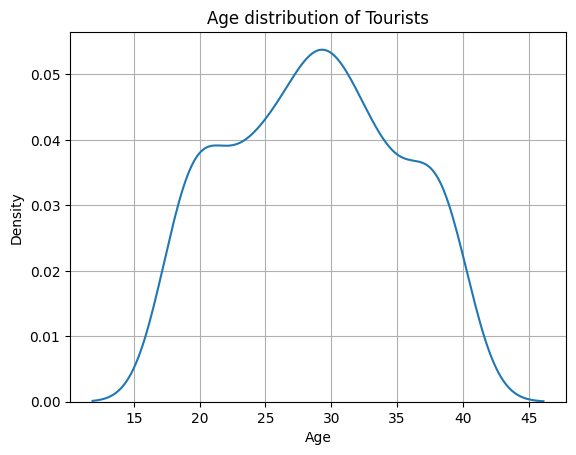

In [56]:
#xcorrecting tables
pdu = PandasUtil()
pdu.get_incorrect_column_names(tourism_rating)
pdu.display_na_rows_cols(tourism_rating,False)
tourism_rating_drop_dupl = pdu.check_and_drop__duplicates(tourism_rating)
pdu.get_incorrect_column_names(tourism_with_id)
pdu.fill_na_with_list_values(tourism_with_id,['Time_Minutes'],'mean')
pdu.display_na_rows_cols(tourism_with_id,False)
tourism_with_id_drop_dupl = pdu.check_and_drop__duplicates(tourism_with_id)
pdu.get_incorrect_column_names(user)
pdu.display_na_rows_cols(user,False)
user_drop_dupl = pdu.check_and_drop__duplicates(user)

#merging tables 
user_rating = pd.merge(user_drop_dupl, \
                       tourism_rating_drop_dupl,\
                       how='left',on='User_Id')
user_rating.shape
user_rating.head()
tourism = pd.merge(user_rating, tourism_with_id_drop_dupl, \
                   how='left', on='Place_Id')
tourism.shape
tourism.head()
sns.kdeplot(data=user_drop_dupl, x='Age')
plt.title('Age distribution of Tourists')
plt.grid(True)
plt.show()

This graph suggests that most of the tourists have an age between 25 and 30 years, with minimum of around 15 years and maximum of around 45 years

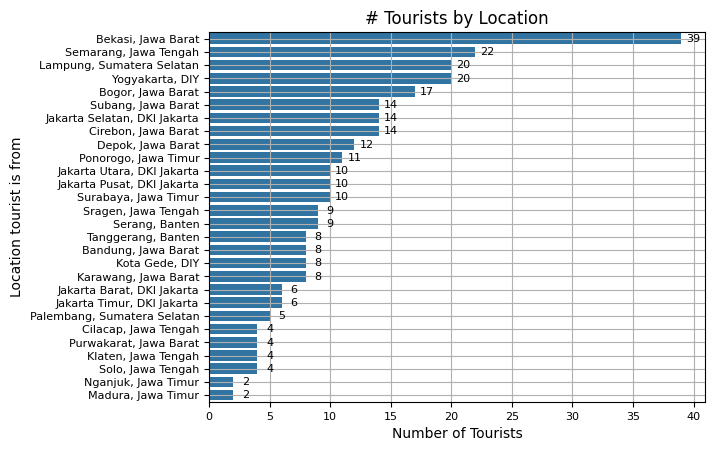

In [57]:
user_location = \
    user_drop_dupl.drop('Age',axis=1).groupby('Location').count().\
    reset_index().sort_values(by='User_Id',ascending=False)
user_location.rename(columns={'User_Id':'Tourist_Count'},inplace=True)
ax = sns.barplot(user_location, x="Tourist_Count", y='Location')
for p in ax.patches:
    width = p.get_width()
    ax.text(x = width + 1, \
            y = p.get_y()+(p.get_height()/2), \
            s = '{:.0f}'.format(width), \
            ha = 'center', va = 'center', \
            fontsize=8)
plt.title('# Tourists by Location')
ax.set_xlabel('Number of Tourists',fontsize=10)
ax.set_ylabel('Location tourist is from',fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)
plt.show()

Most of the tourists are from Bekasi, Jawa Barat (39 tourists). Nganjuk, Jawa Timur and Madura, Jawa Timur are tied for the least number of tourists coming from those places (with 2 tourists)

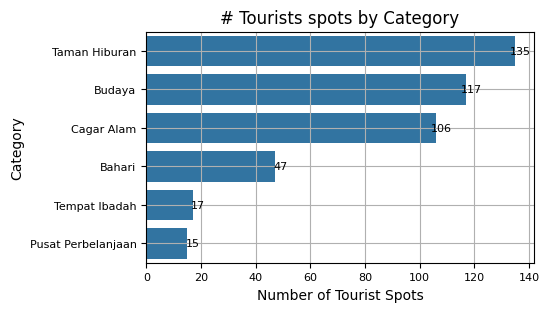

In [58]:
category_spot = \
    tourism_with_id_drop_dupl[['Category','Place_Id']].groupby('Category').count().\
    reset_index().sort_values(by='Place_Id',ascending=False)
category_spot.rename(columns={'Place_Id':'Category_Count'},inplace=True)
plt.figure(figsize=(5,3))
ax = sns.barplot(category_spot, x="Category_Count", y='Category')
for p in ax.patches:
    width = p.get_width()
    ax.text(x = width + 2, \
            y = p.get_y()+(p.get_height()/2), \
            s = '{:.0f}'.format(width), \
            ha = 'center', va = 'center', \
            fontsize=8)
plt.title('# Tourists spots by Category')
ax.set_xlabel('Number of Tourist Spots',fontsize=10)
ax.set_ylabel('Category',fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)
plt.show()

Taman Hiburan has the highest amount of tourists spots with 135 tourist spots.

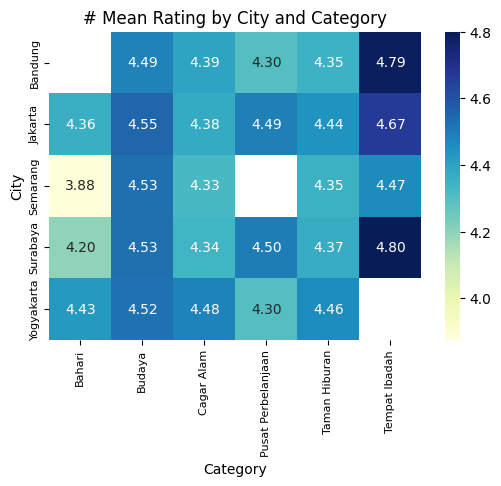

In [59]:
city_category_rating = \
    tourism_with_id_drop_dupl.pivot_table(values='Rating', \
                                          index='City', \
                                          columns='Category', \
                                          aggfunc='mean')
plt.figure(figsize=(6, 4))
plt.title('# Mean Rating by City and Category')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
sns.heatmap(city_category_rating, annot=True, cmap="YlGnBu", fmt='0.2f')
plt.show()

This graph suggests that Tempat Ibadah is the most popular in the City - Bandung, the category Behari is the least popular in the city - Semarang and so on.

In [60]:
tourism_with_id_drop_dupl[\
    (tourism_with_id_drop_dupl.Category == 'Cagar Alam') | \
    (tourism_with_id_drop_dupl.Category == 'Bahari')]\
        [['City','Rating']].groupby('City').mean().reset_index().\
        sort_values(by='Rating',ascending=False)

,City,Rating
4,Yogyakarta,4.449123
0,Bandung,4.394444
1,Jakarta,4.366667
3,Surabaya,4.316667
2,Semarang,4.250000


Yogyakarta has the best rating for nature spots with a rating of 4.

In [61]:
tourism_with_id_drop_dupl[['Place_Name','Rating']].groupby('Place_Name').\
                            mean().reset_index().\
                            sort_values(by='Rating',ascending=False).head()

,Place_Name,Rating
433,Wisata Kuliner Pecenongan,5.0
65,Desa Wisata Sungai Code Jogja Kota,5.0
75,Freedom Library,5.0
144,Kauman Pakualaman Yogyakarta,5.0
184,Masjid Nasional Al-Akbar,4.9


This suggests that Wisata Kuliner Pecenongan, Desa Wisata Sungai Code Jogja Kota, Freedom Library, and Kauman Pakualaman Yogyakarta are all tied for the most popular tourist spot all with a rating of 5.0

In [62]:
tourism_with_id_drop_dupl[['City','Rating']].groupby('City').mean().\
                            reset_index().sort_values(by='Rating',\
                                                      ascending=False)

,City,Rating
1,Jakarta,4.488095
4,Yogyakarta,4.466667
3,Surabaya,4.454348
0,Bandung,4.420968
2,Semarang,4.361404


This suggests that Jakarta is the most popular city with rating of 4.48

In [63]:
tourism_with_id_drop_dupl[['Category','Rating']].groupby('Category').\
                            mean().reset_index().sort_values(\
                                by='Rating',\
                                ascending=False)

,Category,Rating
5,Tempat Ibadah,4.711765
1,Budaya,4.524786
3,Pusat Perbelanjaan,4.440000
4,Taman Hiburan,4.401481
2,Cagar Alam,4.397170
0,Bahari,4.363830


This suggests that Tempat Ibadah is the highest rating place of relgious value with a rating of 4.711

In [64]:
pivot_table = tourism_rating_drop_dupl.pivot_table(index='User_Id', \
                                                   columns='Place_Id', \
                                                   values='Place_Ratings',\
                                                   aggfunc='mean')
pivot_table_filled = pivot_table.fillna(0)
place_similarity = cosine_similarity(sparse.csr_matrix(pivot_table_filled.values.T))
place_similarity_df = pd.DataFrame(place_similarity, \
                                   index=pivot_table_filled.columns, \
                                   columns=pivot_table_filled.columns)
place_similarity_df

Place_Id,1,2,3,4,5,6,7,8,9,10,...,428,429,430,431,432,433,434,435,436,437
Place_Id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.095540,0.252406,0.064487,0.066435,0.000000,0.020106,0.025804,0.009279,0.065436,...,0.125985,0.007770,0.006259,0.028021,0.080238,0.000000,0.054517,0.000000,0.146756,0.064556
2,0.095540,1.000000,0.053904,0.000000,0.072358,0.045977,0.065695,0.033375,0.000000,0.201932,...,0.160087,0.101547,0.093736,0.030519,0.043696,0.003815,0.064326,0.000000,0.025238,0.129437
3,0.252406,0.053904,1.000000,0.022740,0.000000,0.010826,0.000000,0.027298,0.052354,0.000000,...,0.098723,0.000000,0.026486,0.000000,0.045270,0.000000,0.128162,0.183296,0.000000,0.000000
4,0.064487,0.000000,0.022740,1.000000,0.137361,0.000000,0.069284,0.055576,0.165212,0.081428,...,0.036179,0.066935,0.008987,0.000000,0.000000,0.112654,0.130463,0.124392,0.097596,0.008427
5,0.066435,0.072358,0.000000,0.137361,1.000000,0.063578,0.000000,0.058018,0.043923,0.000000,...,0.198781,0.128719,0.091845,0.033159,0.045576,0.000000,0.043009,0.000000,0.036561,0.050003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,0.000000,0.003815,0.000000,0.112654,0.000000,0.000000,0.000000,0.094987,0.175998,0.087096,...,0.069869,0.023268,0.006248,0.073427,0.048058,1.000000,0.122449,0.000000,0.092526,0.011717
434,0.054517,0.064326,0.128162,0.130463,0.043009,0.019876,0.046858,0.025058,0.168205,0.035302,...,0.036250,0.075449,0.032417,0.181406,0.020778,0.122449,1.000000,0.033652,0.240023,0.091185
435,0.000000,0.000000,0.183296,0.124392,0.000000,0.000000,0.148926,0.246885,0.068733,0.000000,...,0.064805,0.038367,0.015454,0.034593,0.000000,0.000000,0.033652,1.000000,0.000000,0.000000


In [65]:
#recommended model building
def recommend_places(user_id, place_id, top_n=5):
    # Get places sorted by similarity
    similar_places = \
        place_similarity_df[place_id].sort_values(ascending=False)

    # Get the places already rated (assumed visited) by the user
    user_rated_places = \
        tourism_rating_drop_dupl[(tourism_rating_drop_dupl.User_Id == \
                                    user_id) & \
                                    (tourism_rating_drop_dupl.Place_Id != \
                                     place_id)].Place_Id

    # Filter the places, the user has already rated/visitied
    similar_not_visited_places = \
        similar_places[~similar_places.index.isin(user_rated_places)]

    # Exclude the place itself
    similar_not_visited_places = \
        similar_not_visited_places[(similar_not_visited_places.index != place_id)]

    # Return the top 'top_n' places
    return similar_not_visited_places.head(top_n)
    

In [66]:
recommend_places(1,5)

Place_Id
82     0.257541
406    0.230906
301    0.219813
97     0.209055
194    0.203247
Name: 5, dtype: float64